In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/yap15-heart-diseases-predictions/sample_submission.csv
/kaggle/input/yap15-heart-diseases-predictions/train.csv
/kaggle/input/yap15-heart-diseases-predictions/test.csv


In [6]:
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
# pd.options.display.float_format = '{:.2f}'.format


In [7]:
df = pd.read_csv('/kaggle/input/yap15-heart-diseases-predictions/train.csv')
df_test = pd.read_csv('/kaggle/input/yap15-heart-diseases-predictions/test.csv')

In [8]:
df['age'] = (df['age'] / 365).round()
df_test['age'] = (df_test['age'] / 365).round()

In [9]:
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50.0,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55.0,1,156,85.0,140,90,3,1,0,0,1,1
2,2,52.0,1,165,64.0,130,70,3,1,0,0,0,1
3,3,48.0,2,169,82.0,150,100,1,1,0,0,1,1
4,4,48.0,1,156,56.0,100,60,1,1,0,0,0,0


In [10]:
df_test.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
0,5,52.0,1,154,85.0,130,80,1,1,0,0,1
1,6,52.0,2,170,69.0,130,90,1,1,0,0,1
2,7,56.0,1,160,70.0,120,75,1,1,0,0,0
3,10,50.0,2,185,94.0,130,90,1,1,0,0,1
4,11,44.0,2,170,76.0,120,80,1,1,0,0,1


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  float64
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(2), int64(11)
memory usage: 6.9 MB


In [12]:
df.cardio.value_counts()

0    35021
1    34979
Name: cardio, dtype: int64

In [13]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,70000.0,49972.419900,28851.302323,0.0,25006.75,50001.5,74889.25,99999.0
age,70000.0,53.338686,6.765294,30.0,48.00,54.0,58.00,65.0
gender,70000.0,1.349571,0.476838,1.0,1.00,1.0,2.00,2.0
height,70000.0,164.359229,8.210126,55.0,159.00,165.0,170.00,250.0
weight,70000.0,74.205690,14.395757,10.0,65.00,72.0,82.00,200.0
ap_hi,70000.0,128.817286,154.011419,-150.0,120.00,120.0,140.00,16020.0
ap_lo,70000.0,96.630414,188.472530,-70.0,80.00,80.0,90.00,11000.0
cholesterol,70000.0,1.366871,0.680250,1.0,1.00,1.0,2.00,3.0
gluc,70000.0,1.226457,0.572270,1.0,1.00,1.0,1.00,3.0
smoke,70000.0,0.088129,0.283484,0.0,0.00,0.0,0.00,1.0


In [14]:
df_test.describe().T

,count,mean,std,min,25%,50%,75%,max
id,30000.0,50062.686900,28906.167148,5.0,24983.25,49995.5,75232.25,99997.0
age,30000.0,53.305467,6.794338,24.0,48.00,54.0,58.00,65.0
gender,30000.0,1.353733,0.478136,1.0,1.00,1.0,2.00,2.0
height,30000.0,164.322267,8.213740,50.0,159.00,165.0,170.00,198.0
weight,30000.0,74.120615,14.341540,10.0,65.00,72.0,82.00,183.0
ap_hi,30000.0,130.271300,212.501152,-130.0,120.00,120.0,140.00,16020.0
ap_lo,30000.0,95.689000,163.852598,-90.0,80.00,80.0,90.00,9100.0
cholesterol,30000.0,1.368033,0.679166,1.0,1.00,1.0,2.00,3.0
gluc,30000.0,1.222700,0.566494,1.0,1.00,1.0,1.00,3.0
smoke,30000.0,0.088600,0.284170,0.0,0.00,0.0,0.00,1.0


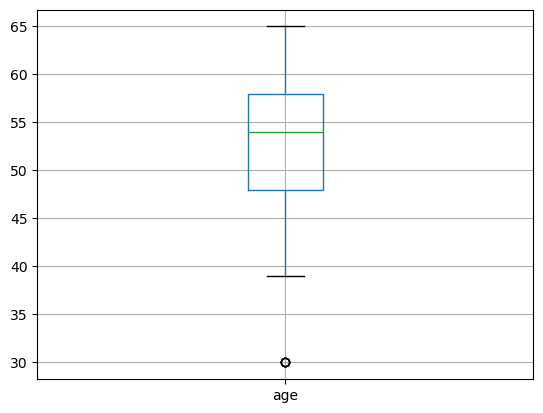

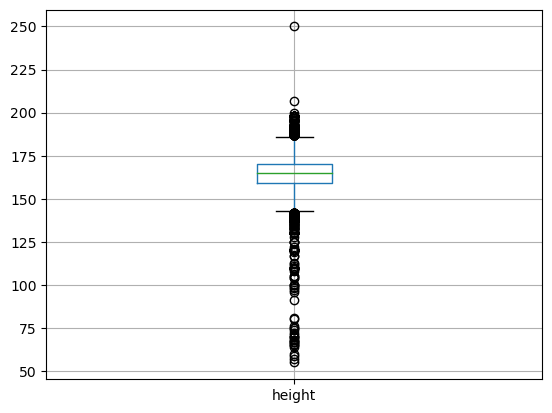

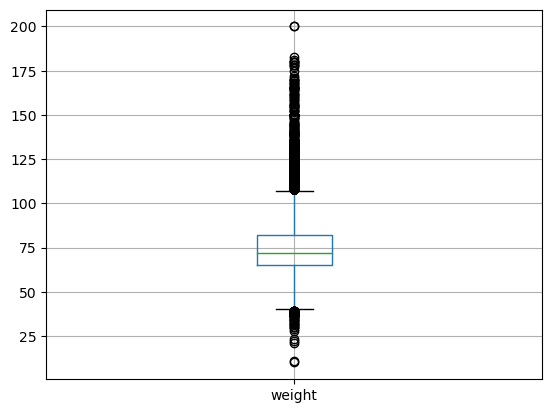

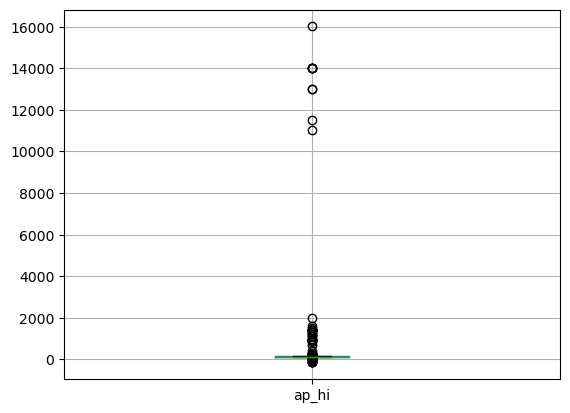

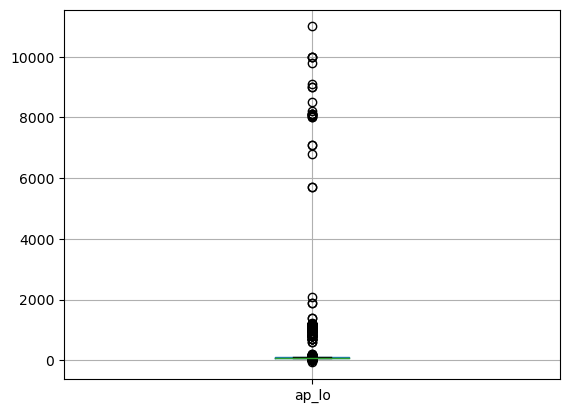

In [15]:
columns = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
for i in columns:
    plt.figure()
    df.boxplot([i])
    plt.show

In [16]:
df[['ap_hi', 'ap_lo']] = df[['ap_hi', 'ap_lo']].abs()
df_test[['ap_hi', 'ap_lo']] = df_test[['ap_hi', 'ap_lo']].abs()

In [17]:
def pression(ap):
    if ap > 4000:
        return ap / 100
    elif ap > 400:
        return ap / 10
    return ap

In [18]:
df['ap_hi'] = df['ap_hi'].apply(pression)
df['ap_lo'] = df['ap_lo'].apply(pression)
df['ap_hi'] = df['ap_hi'].where(df['ap_hi'] > 30, df['ap_hi'] * 10)
df_test['ap_hi'] = df_test['ap_hi'].apply(pression)
df_test['ap_lo'] = df_test['ap_lo'].apply(pression)
df_test['ap_hi'] = df_test['ap_hi'].where(df_test['ap_hi'] > 30, df_test['ap_hi'] * 10)

In [19]:
df['sum_ap'] = df['ap_hi'] + df['ap_lo']
df_test['sum_ap'] = df_test['ap_hi'] + df_test['ap_lo']

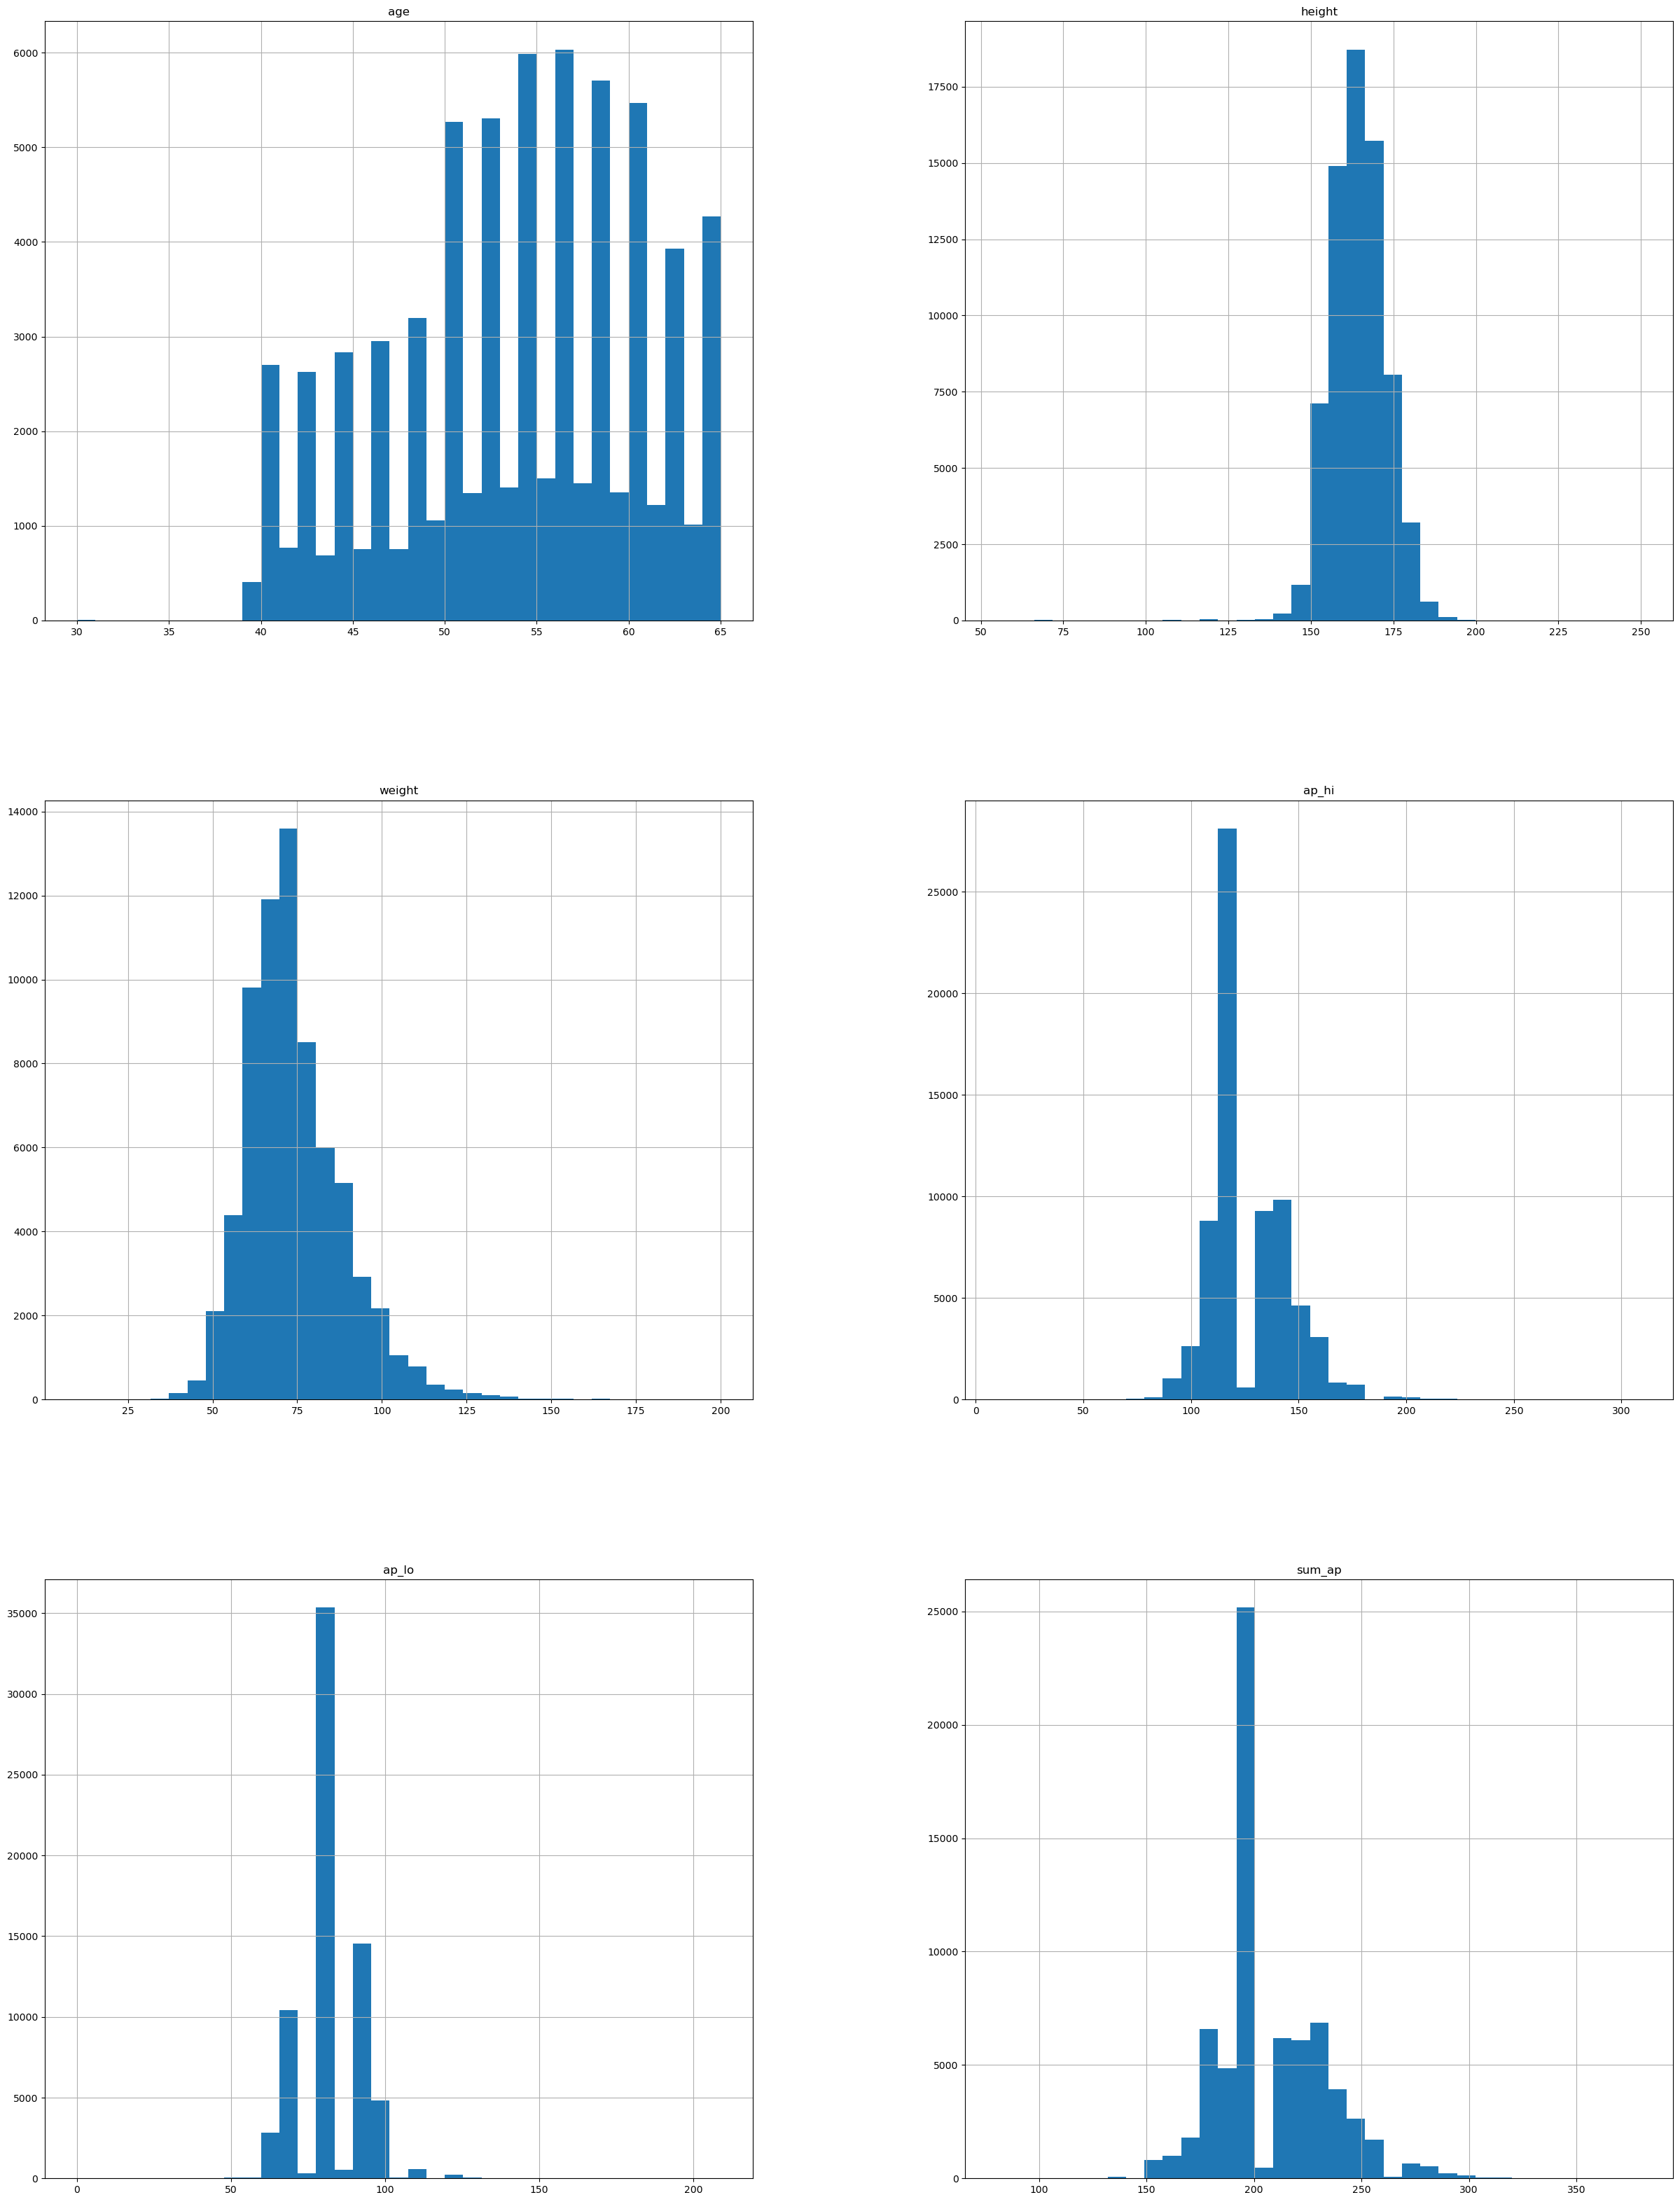

In [20]:
df.hist(['age', 'height', 'weight', 'ap_hi', 'ap_lo', 'sum_ap'],figsize=(30,40), bins=35)
plt.show()

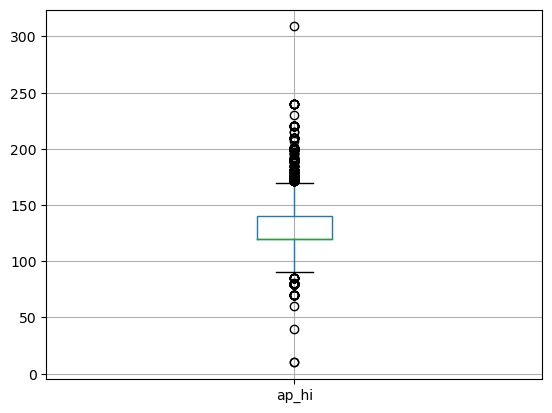

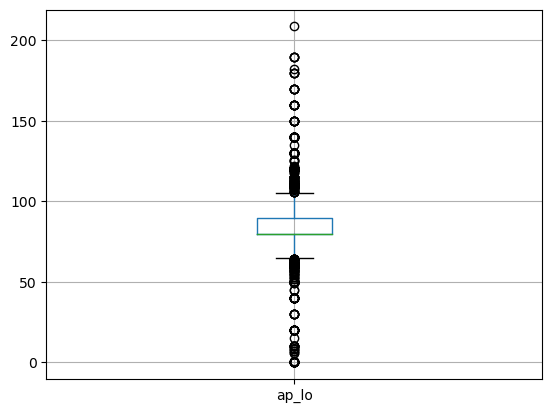

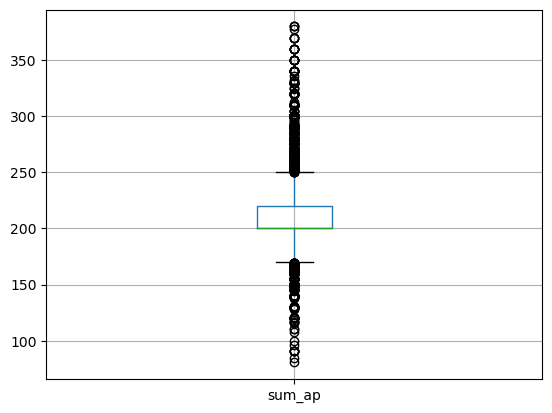

In [21]:
columns = ['ap_hi', 'ap_lo', 'sum_ap']
for i in columns:
    plt.figure()
    df.boxplot([i])
    plt.show

In [22]:
df['height'] = df['height'].where(df['height'] >= 100, df['height'] + 100)
df_test['height'] = df_test['height'].where(df_test['height'] >= 100, df_test['height'] + 100)

In [23]:
for sex in df['gender'].unique():
    df.loc[(df['gender'] == sex) & ((df['height'] >= 100) & (df['height'] < 130)), 'height'] = df.loc[(df['gender'] == sex), 'height'].median()

In [24]:
for sex in df_test['gender'].unique():
    df_test.loc[(df_test['gender'] == sex) & ((df_test['height'] >= 100) & (df_test['height'] < 130)), 'height'] = df_test.loc[(df_test['gender'] == sex), 'height'].median()

In [25]:
for sex in df['gender'].unique():
    df.loc[(df['gender'] == sex) & ((df['weight'] < 40)), 'weight'] = df.loc[(df['gender'] == sex), 'weight'].median()

In [26]:
for sex in df_test['gender'].unique():
    df_test.loc[(df_test['gender'] == sex) & ((df_test['weight'] < 40)), 'weight'] = df_test.loc[(df_test['gender'] == sex), 'weight'].median()

In [27]:
df['bmi'] = (df['weight'] / (df['height'] / 100) ** 2).round(2)
df_test['bmi'] = (df_test['weight'] / (df_test['height'] / 100) ** 2).round(2)

In [28]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,70000.0,49972.419900,28851.302323,0.00,25006.75,50001.5,74889.25,99999.00
age,70000.0,53.338686,6.765294,30.00,48.00,54.0,58.00,65.00
gender,70000.0,1.349571,0.476838,1.00,1.00,1.0,2.00,2.00
height,70000.0,164.444143,7.867426,130.00,159.00,165.0,170.00,250.00
weight,70000.0,74.232941,14.353096,40.00,65.00,72.0,82.00,200.00
ap_hi,70000.0,126.996094,17.142550,10.00,120.00,120.0,140.00,309.00
ap_lo,70000.0,81.602571,10.177419,0.00,80.00,80.0,90.00,208.80
cholesterol,70000.0,1.366871,0.680250,1.00,1.00,1.0,2.00,3.00
gluc,70000.0,1.226457,0.572270,1.00,1.00,1.0,1.00,3.00
smoke,70000.0,0.088129,0.283484,0.00,0.00,0.0,0.00,1.00


In [29]:
df_test.describe().T

,count,mean,std,min,25%,50%,75%,max
id,30000.0,50062.686900,28906.167148,5.00,24983.25,49995.50,75232.25,99997.00
age,30000.0,53.305467,6.794338,24.00,48.00,54.00,58.00,65.00
gender,30000.0,1.353733,0.478136,1.00,1.00,1.00,2.00,2.00
height,30000.0,164.398633,7.842494,130.00,159.00,165.00,170.00,198.00
weight,30000.0,74.155871,14.282894,40.00,65.00,72.00,82.00,183.00
ap_hi,30000.0,127.017103,17.147367,10.00,120.00,120.00,140.00,400.00
ap_lo,30000.0,81.640177,10.114311,0.00,80.00,80.00,90.00,208.80
cholesterol,30000.0,1.368033,0.679166,1.00,1.00,1.00,2.00,3.00
gluc,30000.0,1.222700,0.566494,1.00,1.00,1.00,1.00,3.00
smoke,30000.0,0.088600,0.284170,0.00,0.00,0.00,0.00,1.00


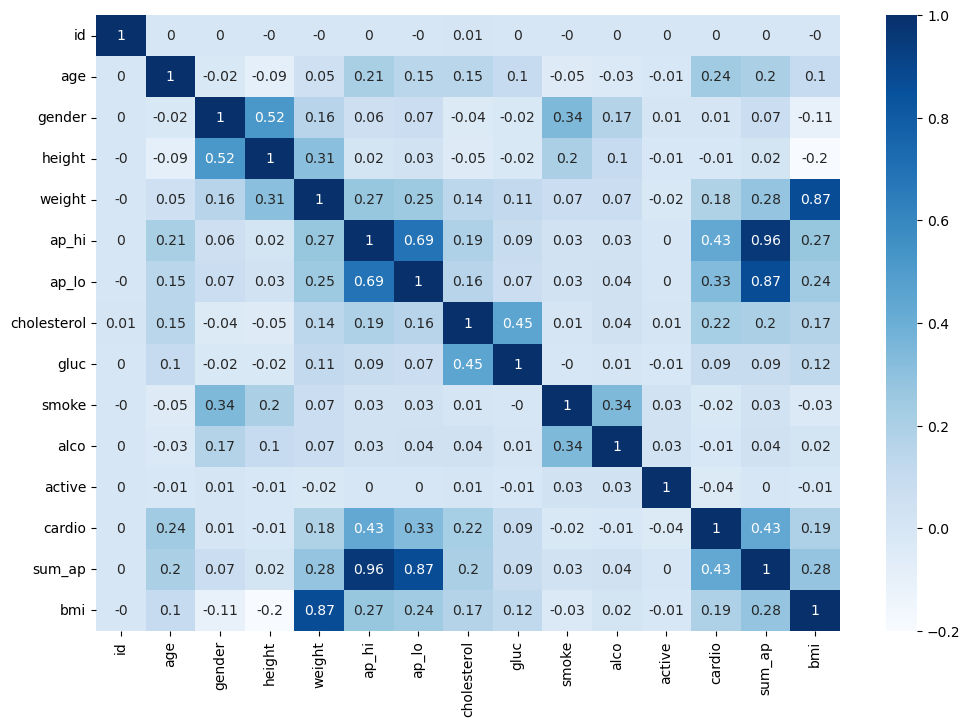

In [30]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr().round(2), annot=True, cmap='Blues')
plt.show()

In [31]:
features = df.drop(['id', 'cardio'], axis=1)
target = df['cardio']

In [32]:
x_train, x_valid, y_train, y_valid = train_test_split(features, target, test_size=.25, random_state=1)

In [33]:
model = RandomForestClassifier(n_estimators=90, max_depth=12, min_samples_leaf=4, random_state=1)
model.fit(x_train, y_train)
predicted_valid = model.predict(x_valid)
probabilities_valid = model.predict_proba(x_valid)
probabilities_one_valid = probabilities_valid[:, 1]

roc_auc = roc_auc_score(y_valid, probabilities_one_valid)
print("ROC_AUC:", roc_auc)

ROC_AUC: 0.8032454834084002


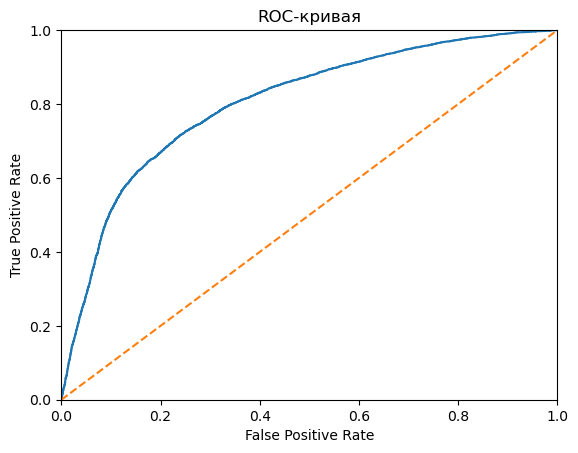

In [34]:
fpr, tpr, thresholds = roc_curve(y_valid, probabilities_one_valid)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

In [35]:
# Определение важности признаков
features_importance = pd.DataFrame({'name':x_train.columns,'features_importance':model.feature_importances_})
features_importance.sort_values('features_importance',ascending=False).reset_index(drop=True)

,name,features_importance
0,ap_hi,0.289169
1,sum_ap,0.233241
2,age,0.115982
3,ap_lo,0.099247
4,cholesterol,0.076698
5,bmi,0.069661
6,weight,0.044504
7,height,0.034442
8,gluc,0.012517
9,active,0.009522


In [36]:
df_test.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,sum_ap,bmi
0,5,52.0,1,154,85.0,130.0,80.0,1,1,0,0,1,210.0,35.84
1,6,52.0,2,170,69.0,130.0,90.0,1,1,0,0,1,220.0,23.88
2,7,56.0,1,160,70.0,120.0,75.0,1,1,0,0,0,195.0,27.34
3,10,50.0,2,185,94.0,130.0,90.0,1,1,0,0,1,220.0,27.47
4,11,44.0,2,170,76.0,120.0,80.0,1,1,0,0,1,200.0,26.30


In [37]:
test = df_test.drop(['id'], axis=1)

In [38]:
df_test.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,sum_ap,bmi
0,5,52.0,1,154,85.0,130.0,80.0,1,1,0,0,1,210.0,35.84
1,6,52.0,2,170,69.0,130.0,90.0,1,1,0,0,1,220.0,23.88
2,7,56.0,1,160,70.0,120.0,75.0,1,1,0,0,0,195.0,27.34
3,10,50.0,2,185,94.0,130.0,90.0,1,1,0,0,1,220.0,27.47
4,11,44.0,2,170,76.0,120.0,80.0,1,1,0,0,1,200.0,26.30


In [39]:
probabilities_test = model.predict_proba(test)
prob_one_test = probabilities_test[:, 1]
cardio = pd.DataFrame(prob_one_test, columns=['cardio'])
df_test_res = df_test.join(cardio)

In [40]:
df_test_res.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,sum_ap,bmi,cardio
0,5,52.0,1,154,85.0,130.0,80.0,1,1,0,0,1,210.0,35.84,0.500136
1,6,52.0,2,170,69.0,130.0,90.0,1,1,0,0,1,220.0,23.88,0.555227
2,7,56.0,1,160,70.0,120.0,75.0,1,1,0,0,0,195.0,27.34,0.374606
3,10,50.0,2,185,94.0,130.0,90.0,1,1,0,0,1,220.0,27.47,0.577663
4,11,44.0,2,170,76.0,120.0,80.0,1,1,0,0,1,200.0,26.30,0.229890


In [41]:
result = df_test_res[['id', 'cardio']]

In [42]:
result.head()

,id,cardio
0,5,0.500136
1,6,0.555227
2,7,0.374606
3,10,0.577663
4,11,0.229890


In [43]:
result.to_csv('result.csv', index=False)

In [44]:
from pickle import dump

In [45]:
with open ('model.pcl', "wb") as fid:
    dump(model, fid)